## Manipulating and Modeling Time Series Data

### Data Set Up

Airline Passenger Data: https://www.kaggle.com/rakannimer/air-passengers

(it's a pretty common dataset, available in several different places, but here's a source)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

In [2]:
# If you want to install pmdarima (plus a link to the documentation)
# http://alkaline-ml.com/pmdarima/
#!pip install pmdarima

In [3]:
# Read df
air_df = pd.read_csv('data/airline_passengers.csv')

In [4]:
# Check the shape of the data
air_df.shape

(144, 2)

In [5]:
# Check the first 10 rows...
air_df.head(10)

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [6]:
# Let's go ahead and set the index to be a datetime index
# First making it a datetime object
air_df['Month'] = pd.to_datetime(air_df['Month'])

# Now making it our index
air_df.set_index('Month', inplace=True)

In [7]:
# Now let's look at how that impacted the time/index
air_df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
air_df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [9]:
air_df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

*Frequency is `MS` <br> Start of Month*

In [10]:
air_df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [11]:
air_df.index.freq = 'MS'

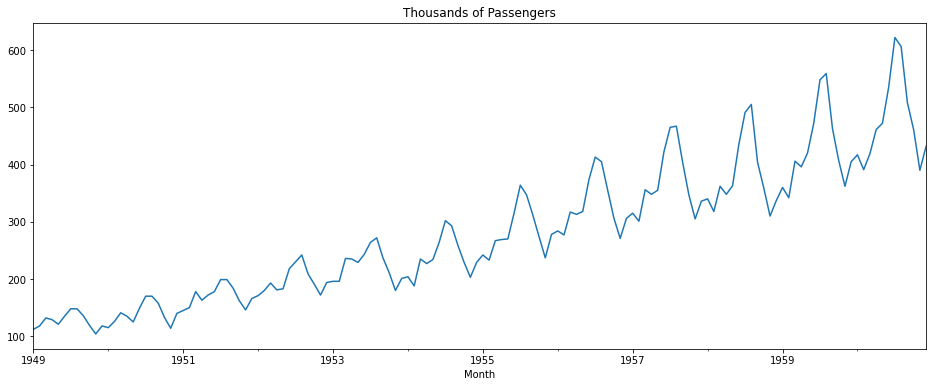

In [12]:
# Let's get a sense of the data
plt.figure(figsize=(16,6))
air_df['Thousands of Passengers'].plot()
plt.title('Thousands of Passengers')
plt.show()

Now we can see the general trends in our data.

Also! This is why we change our data to use the datetime object as the index - makes EVERYTHING easier!

*It's not stationary but I think I can make it stationary*

## Changing the frequency of our data 

Also called downsampling or upsampling, depending on whether you're going to a less frequent or more frequent point in time.

[Here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling) is a reference for resampling based on time frequency. (you can find the actual codes you can use as arguments in the resample function [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)).

*Notice the documentation links to find the different date frequency strings (like "MS"*

In [13]:
# Upsampling to a daily cadence
df_daily = air_df.resample('D').mean()

In [14]:
df_daily.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-01-02,NaN
1949-01-03,NaN
1949-01-04,NaN
1949-01-05,NaN


In [15]:
# Ew - nulls!
df_daily.isna().sum()

Thousands of Passengers    4209
dtype: int64

Of course we have nulls though - we took monthly data and tried to make it daily!

But what about downsampling to quarterly?

In [16]:
# Here we're downsampling to quarter
# Note that there are a few different ways to define 'quarter'
df_quarterly = air_df.resample('Q').mean()
df_quarterly.head()

,Thousands of Passengers
Month,
1949-03-31,120.666667
1949-06-30,128.333333
1949-09-30,144.000000
1949-12-31,113.666667
1950-03-31,127.333333


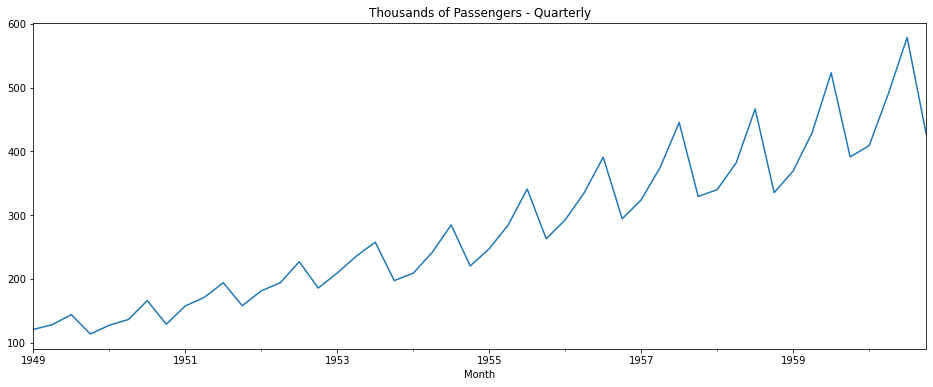

In [17]:
# Again, visualizing the Average Opening price
plt.figure(figsize=(16,6))
df_quarterly['Thousands of Passengers'].plot()
plt.title('Thousands of Passengers - Quarterly')
plt.show()

So, as would make sense, as you change the frequency of your data it changes the granularity (level of detail) that's conveyed.

### Stationarity

Introduction to stationarity from [_Forecasting: Principles and Practice_](https://otexts.com/fpp2/stationarity.html):

> "A stationary time series is one whose properties do not depend on the time at which the series is observed.14 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.
>
> "Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.
>
> "In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance."

And here's a [useful blog post](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322) on the subject, where I found the below demonstrative image:

![Examples of stationary and non-stationary processes, from the above medium blog](https://miro.medium.com/max/1400/1*tkx0_wwQ2JT7pSlTeg4yzg.png)

#### Why do we want to get a stationary series?

> "Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time."

- [Source](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322)

Biggest reason: makes the data easier to model!

In [18]:
# Let's  get the rolling mean and rolling standard deviation, using a 12-month window

roll_mean = air_df['Thousands of Passengers'].rolling(window=12, center=False).mean()
roll_std = air_df['Thousands of Passengers'].rolling(window=12, center=False).std()

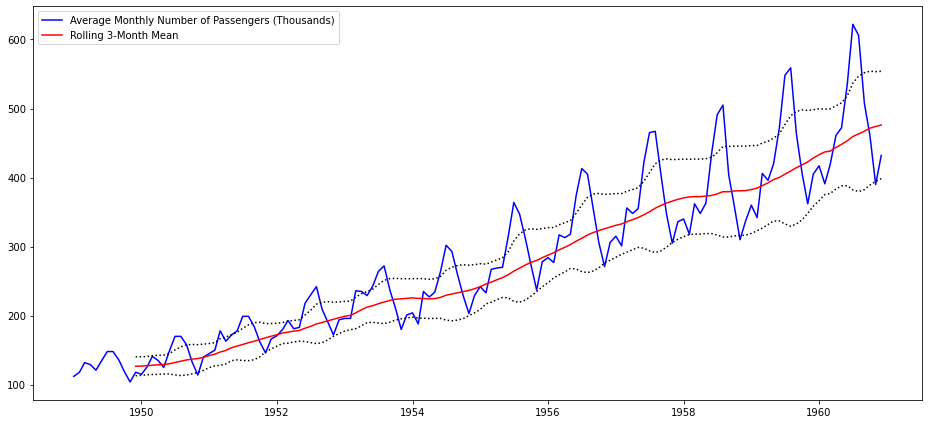

In [19]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(air_df['Thousands of Passengers'], color='blue',
        label='Average Monthly Number of Passengers (Thousands)')

ax.plot(roll_mean, color='red', label='Rolling 3-Month Mean')

ax.plot(roll_mean + roll_std, color='black', linestyle='dotted')
ax.plot(roll_mean - roll_std, color='black', linestyle='dotted')

ax.legend()
fig.tight_layout()

Do you think this data is stationary? Why or why not?

 - 
 

There's a test for this!

> **Augumented Dickey-Fuller test**: a hypothesis test, where we reject the null hypothesis (that a time series is non-stationary) if the test-statistic is less than the critical value

[Documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) for the Dickey-Fuller test in StatsModels

So let's write out our null and alternative hypotheses (remember these??):

Ho = 

Ha = 

In [20]:
# Feed in our column, since the test function expects a series:
adfuller(air_df['Thousands of Passengers'])

(0.8153688792060472,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Let's interpret the output of this test:

- 


In [21]:
# Now that we've determined whether the data is stationary, let's decompose it

# Using the decompose function from pmdarima
# Need to feed it an array, hence the .values attribute
decomposed = decompose(air_df['Thousands of Passengers'].values, 'multiplicative', m=12)

# M? See this: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period

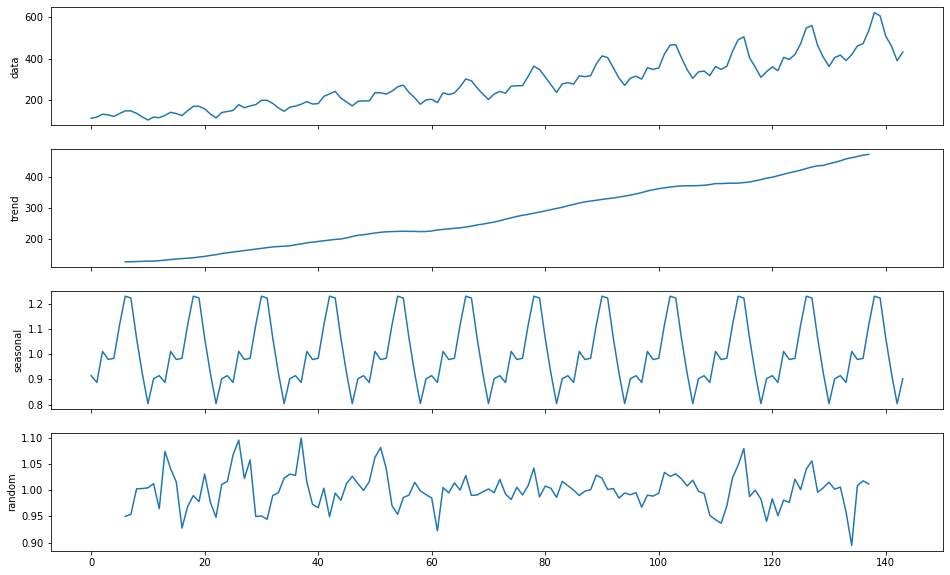

In [22]:
# Plotting the pieces using the arima model again
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

From the documentation for `pmdarima`'s decompose:: 

> So what is happening when we call `decomposed`?
> 1) The trend is extracted from the signal via a convolution using either a
   SMA or a user-defined filter.
>   
> 2) We remove the effects of the trend from the original signal by either
   subtracting its effects or dividing out its effects for 'additive' or
   'multiplicative' types of decompositions, respectively. We then take the
   mean across all seasons to get the values for a single season. For m=4, we
   expect 4 values for a single season.
>
> 3) We then create the seasonal series by replicating the single season
   until it is the same length of the trend signal.
>
> 4) Lastly to get the random/noise elements of the signal we remove the effects
   of both the trend and seasonal series and we are now left with the
   variation of the original signal that is neither explainable by seasonal
   nor trend effects.
>
> This logic produces a named tuple of the original signal, trend, seasonal, and random components. It is this named tuple that is passed to `decomposed_plot`

#### Additive vs Multiplicative?

It's in the trends of the plots: 

| Additive Example | Multiplicative Example |
| ---------------- | ---------------------- |
| ![from the pmdarima documentation: additive example](images/sphx_glr_example_seasonal_decomposition_001.png) | ![from the pmdarima documentation: multiplicative example](images/sphx_glr_example_seasonal_decomposition_002.png) |

[Source](https://alkaline-ml.com/pmdarima/auto_examples/arima/example_seasonal_decomposition.html)

Can you spot the difference?

*Additive: the size of the first hill is the same as the size of the last hill <br> For multiplicative, the size of the last hill is bigger than the first hill*

## Now - Time to Model!

In [23]:
# New dataset who dis
# Monthly Google search trends for 'taxes' in the US
df_taxes = pd.read_csv('data/google-trends_taxes_us.csv')

# Some quick clean up
df_taxes.columns = ['counts']
df_taxes = df_taxes.iloc[1:] #1st for is a junk 1st row
df_taxes['counts'] = df_taxes['counts'].str.replace('<1', '0').astype(int) #some strings are <1
df_taxes.index = pd.to_datetime(df_taxes.index)

*Frequency is "MS" again*

In [24]:
df_taxes.head()

,counts
2004-01-01,45
2004-02-01,54
2004-03-01,48
2004-04-01,56
2004-05-01,24


In [25]:
df_taxes.tail()

,counts
2019-01-01,78
2019-02-01,100
2019-03-01,70
2019-04-01,81
2019-05-01,35


<AxesSubplot:>

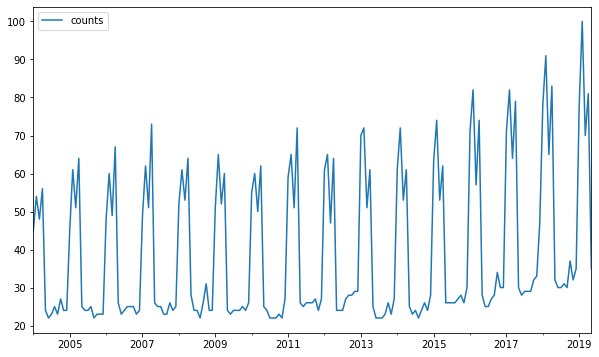

In [26]:
df_taxes.plot(figsize=(10,6))

In [27]:
# If we check out the index, you see freq=None
df_taxes.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01'],
              dtype='datetime64[ns]', length=185, freq=None)

In [28]:
# Let's set that freq to be MS (month start)
df_taxes.index.freq = 'MS'
df_taxes.index

DatetimeIndex(['2004-01-01', '2004-02-01', '2004-03-01', '2004-04-01',
               '2004-05-01', '2004-06-01', '2004-07-01', '2004-08-01',
               '2004-09-01', '2004-10-01',
               ...
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01'],
              dtype='datetime64[ns]', length=185, freq='MS')

*She thinks it's additive becuase there isn't much difference between the 1st hill and last hill*

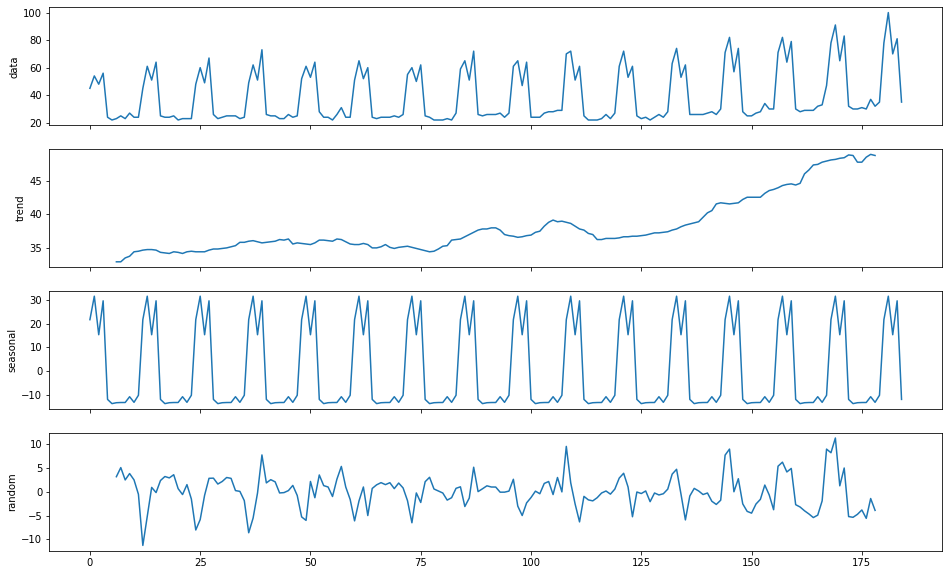

In [29]:
# Let's decompose this one

decomposed = decompose(df_taxes['counts'].values, 'additive', m=12)

decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

## ARMA Modeling 

Once you determine if your time series is stationary, you can model. There are 4 key steps: 
1. Model Identification - where you determine the properties of a time series then chose a structural form. Remember you're treating the data as a series of random variables. The basic types of ARIMA models are: 
    - AutoRegressive(AR)
    - Moving Average(MA) 
    - AutoRegressive Moving Average(ARMA)
    - AutoRegressive Integrated Moving Average(ARIMA)

A time series may be primarily an autoregressive, moving average or combination of both. To identify which it is, you need to plot 2 key functions.

    > Sample Autocorrelation Function(ACF) 
    > Sample Partial Autocorrelation Function(Partial ACF)
    
2. Parameter Estimation - Once you have identified the form of an ARIMA model, the next step is to estimate the coefficients or parameters of the model. You can use Regression and MLE to do this. 

3. Model Checking - The most widely used information criterion(checking the quality of your model) for time series is AIC. You can compare different models with different numbers of lagged terms, white noise terms and how many times the time series was differenced and choose the model with the lowest AIC. 

4. Forecasting - Once the model is estimated you can forecast future values with the predict function. 

![](https://www.statisticshowto.com/wp-content/uploads/2016/11/lag-plot-linear.png)

## Autocorrelation and Partial Autocorrelation
The ACF shows the correlations between the elements of a time series as a function of their lags. The partial ACF shows the correlations between the elements of a time series for each lag, holding constant the impact of all other lags.

### Autocorrelation Function Plots

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

> "The **autocorrelation function** is a function that represents autocorrelation of a time series as a function of the time lag."

The autocorrelation function tells interesting stories about trends and seasonality. For example, if the original time series repeats itself every five days, you would expect to see a spike in the autocorrelation function at 5 days.



In [30]:
df_taxes['counts']

2004-01-01     45
2004-02-01     54
2004-03-01     48
2004-04-01     56
2004-05-01     24
             ... 
2019-01-01     78
2019-02-01    100
2019-03-01     70
2019-04-01     81
2019-05-01     35
Freq: MS, Name: counts, Length: 185, dtype: int64

In [31]:
df_taxes['lag 1'] = df_taxes['counts'].shift(1) 
#Create new columns that are shifted by 1 to get that lag

In [32]:
df_taxes['lag 12'] = df_taxes['counts'].shift(12)
#And then shifted by 12 to get the lag

In [33]:
df_taxes.head(15)

,counts,lag 1,lag 12
2004-01-01,45,NaN,NaN
2004-02-01,54,45.0,NaN
2004-03-01,48,54.0,NaN
2004-04-01,56,48.0,NaN
2004-05-01,24,56.0,NaN
2004-06-01,22,24.0,NaN
2004-07-01,23,22.0,NaN
2004-08-01,25,23.0,NaN
2004-09-01,23,25.0,NaN
2004-10-01,27,23.0,NaN


*What do you notice about some the lags? <br> number of NaN is the same as the number of lags<br> There is a yearly trend. Value for January 2004 is identical to January 2005. And February 2004 is similar to February 2005 <br> So, It's more useful to look at last year than last month <br> We can do a correlation to check*

In [34]:
df_taxes.corr()

,counts,lag 1,lag 12
counts,1.000000,0.592494,0.982597
lag 1,0.592494,1.000000,0.576508
lag 12,0.982597,0.576508,1.000000


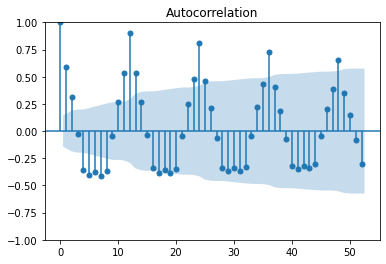

In [35]:
import statsmodels.graphics.tsaplots as tsa

tsa.plot_acf(df_taxes['counts'],lags=52);

*Each number along the x-axis represents an individual lag*

*It just plots how each lag correlates to the original <br> lag = 12 has a .98 correlation <br> and lag = 1 has a .58 correlation*

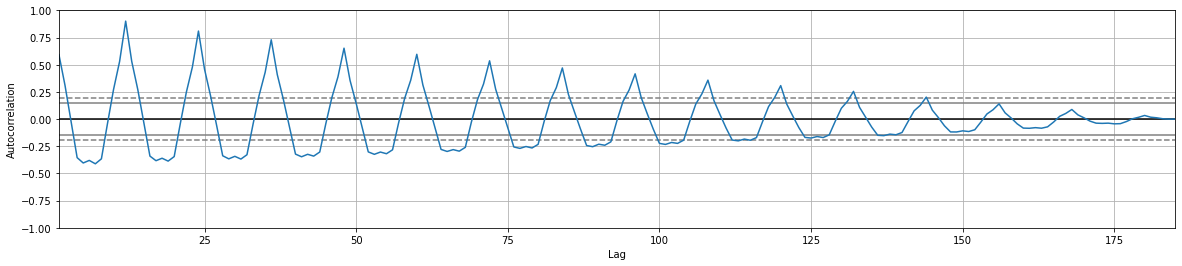

In [36]:
# Another view
plt.figure(figsize=(20, 4))
pd.plotting.autocorrelation_plot(df_taxes['counts']); #same plot but from pandas

The horizontal bands represent condfidence intervals, which are calculated by taking relevant z-scores of the standard normal distribution and dividing by the square root of the number of observations. What do these intervals mean? - anything outside confidence interval means not due to chance - reject null. 


In [37]:
import statsmodels as sm
sm.__version__

'0.13.0'

### Partial-Autocorrelation Function Plot


> "The **partial autocorrelation function** can be interpreted as a regression of the series against its past lags.
 
 > It helps you come up with a possible order for the auto regressive term. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant. "

The idea behind Partial Autocorrelation is to compare a series to a lagged version of itself while abstracting away from intermediate values. In effect, this amounts to exploring the correlations among residuals

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


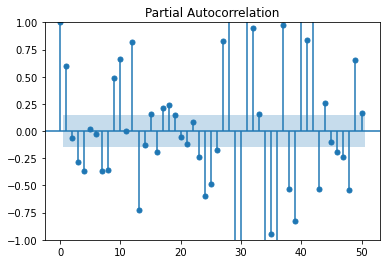

In [38]:
tsa.plot_pacf(df_taxes['counts'],lags=50);

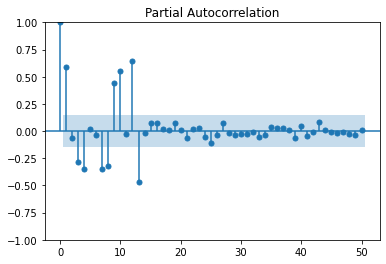

In [39]:
tsa.plot_pacf(df_taxes['counts'],lags=50, method = 'ywm');

# ARIMA MODELS:


## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoRegressive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

### Number of AR (Auto-Regressive) terms (p): 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q): 

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

What you generally will try to do for any time series analysis is:

- Detrend your time series using differencing. ARMA models represent stationary processes, so we have to make sure there are no trends in our time series
- Look at ACF and PACF of the time series
- Decide on the AR, MA, and order of these models
- Fit the model to get the correct parameters and use for prediction

In [40]:
# metrics
from sklearn import metrics

# Note - we're back to regression metrics!
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [41]:
# Getting rid of those earlier lag cols
df_taxes = df_taxes.drop(columns=['lag 1', 'lag 12'])

In [42]:
# Back to taxes
# Let's create a time period tracker - incrementing each instance
df_taxes.insert(0, 't', range(len(df_taxes)))
df_taxes.head()

,t,counts
2004-01-01,0,45
2004-02-01,1,54
2004-03-01,2,48
2004-04-01,3,56
2004-05-01,4,24


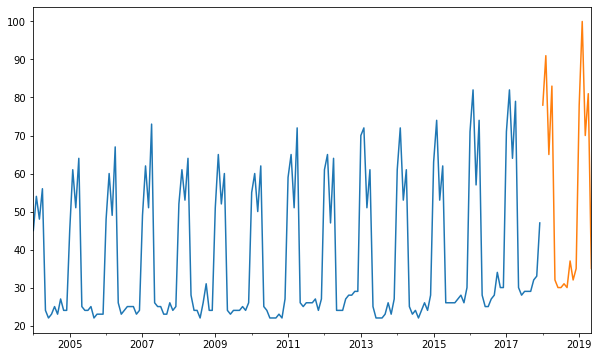

In [43]:
# Let's create a target area
df_taxes['future'] = (df_taxes.index.year > 2017).astype('int')

# Now plot
plt.figure(figsize=(10,6))
df_taxes.loc[df_taxes.future == 0, 'counts'].plot()
df_taxes.loc[df_taxes.future == 1, 'counts'].plot()
plt.show()

In [44]:
df_taxes.tail(20)

,t,counts,future
2017-10-01,165,32,0
2017-11-01,166,33,0
2017-12-01,167,47,0
2018-01-01,168,78,1
2018-02-01,169,91,1
2018-03-01,170,65,1
2018-04-01,171,83,1
2018-05-01,172,32,1
2018-06-01,173,30,1
2018-07-01,174,30,1


In [45]:
# Here, just using the instance as our "X" - not really what we're using to predict
# But - this is setting us up for something later (linear predictions)
X_train = df_taxes.loc[df_taxes.future == 0, 't'].values.reshape(-1, 1)
X_test = df_taxes.loc[df_taxes.future == 1, 't'].values.reshape(-1, 1)
# Our train set is our actual value in the series
y_train = df_taxes.loc[df_taxes.future == 0, 'counts'].values
y_test = df_taxes.loc[df_taxes.future == 1, 'counts'].values

#### What's the most naive way to make a prediction?

- The average of the total train set
- You could also predict the last value continued


In [46]:
y_pred = df_taxes.loc[df_taxes.future == 0, 'counts'].mean()
#Same as: 
#y_pred = y_train.mean()
y_pred

37.18452380952381

In [47]:
y_preds = [y_pred]*len(y_test)

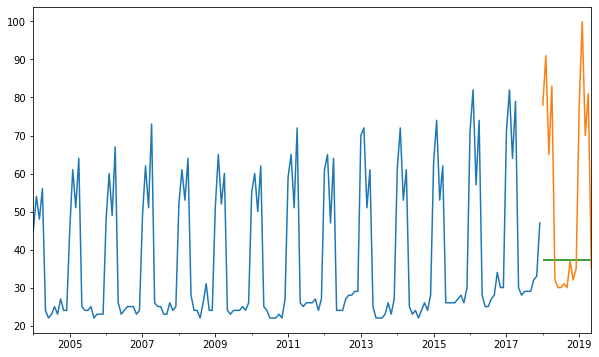

In [48]:
# Plot your naive predictions
plt.figure(figsize=(10,6))
df_taxes.loc[df_taxes.future == 0, 'counts'].plot()
df_taxes.loc[df_taxes.future == 1, 'counts'].plot()

# Predictions go here
plt.hlines(y=y_pred, 
           xmin=df_taxes.loc[df_taxes.future == 1, 'counts'].index[0],
           xmax=df_taxes.loc[df_taxes.future == 1, 'counts'].index[-1],
           color = 'green')


plt.show()

In [49]:
# How right are we?
report_metrics(y_test, y_preds)

Explained Variance:
	 0.0
MAE:
	 23.010854341736692
RMSE:
	 30.964441769201944
r^2:
	 -0.5097103248808332


Thoughts? 

- eek


#### Another Naive Approach - Linear Trend

In [50]:
# linear trend approach
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_trend = lr.predict(X_train)

In [51]:
X_train

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [52]:
y_pred

array([40.51568292, 40.55510492, 40.59452692, 40.63394892, 40.67337093,
       40.71279293, 40.75221493, 40.79163693, 40.83105893, 40.87048093,
       40.90990293, 40.94932493, 40.98874694, 41.02816894, 41.06759094,
       41.10701294, 41.14643494])

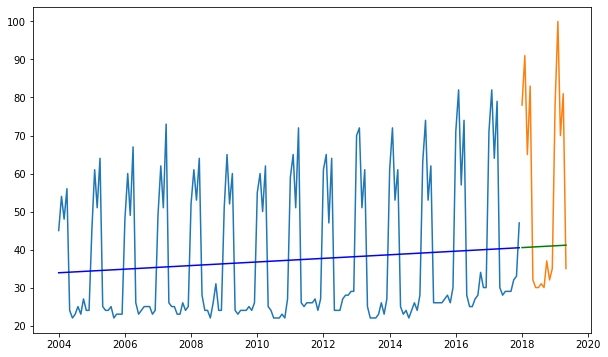

In [53]:
plt.figure(figsize=(10,6))
#plt.plot(df_taxes['counts'])
plt.plot(df_taxes.loc[df_taxes.future == 0, 'counts'])
plt.plot(df_taxes.loc[df_taxes.future == 1, 'counts'])
plt.plot(df_taxes.loc[df_taxes.future == 0].index, y_trend, color = 'blue')
plt.plot(df_taxes.loc[df_taxes.future == 1].index, y_pred, color='green')
plt.show()

In [54]:
report_metrics(y_test, y_pred)

Explained Variance:
	 -0.000715977559534231
MAE:
	 23.243907937692313
RMSE:
	 29.005724409353874
r^2:
	 -0.3247518907038842


Thoughts? 

- Arguably worse than just guessing the mean
- Still bad but it's trying it's best


### ARIMA!

In [55]:
# Import ARMA
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARMA model - what should our parameters be?
arima_order = (1,1,0) #should be a tuple, like (0,0,0)
mod_arima = ARIMA(df_taxes.loc[df_taxes.future == 0]['counts'], 
                 order=arima_order)
res_arima = mod_arima.fit()

# Print out summary information on the fit
print(res_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  168
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -701.275
Date:                Mon, 08 Nov 2021   AIC                           1406.551
Time:                        21:42:50   BIC                           1412.787
Sample:                    01-01-2004   HQIC                          1409.082
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1582      0.094     -1.678      0.093      -0.343       0.027
sigma2       259.9445     24.848     10.461      0.000     211.242     308.647
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [56]:
# Now, to make more predictions, how many steps do we want?
len(y_test)

17

In [57]:
# Returns 1 things - forecast
#It used to return 3 things, including the standard error and confidence interval
res_arima.forecast(steps = len(y_test))

2018-01-01    44.785393
2018-02-01    45.135713
2018-03-01    45.080298
2018-04-01    45.089064
2018-05-01    45.087677
2018-06-01    45.087896
2018-07-01    45.087862
2018-08-01    45.087867
2018-09-01    45.087866
2018-10-01    45.087866
2018-11-01    45.087866
2018-12-01    45.087866
2019-01-01    45.087866
2019-02-01    45.087866
2019-03-01    45.087866
2019-04-01    45.087866
2019-05-01    45.087866
Freq: MS, Name: predicted_mean, dtype: float64

In [58]:
# Saving these predictions to more easily visualize
future_df = df_taxes.loc[df_taxes.future == 1].copy()
future_df['preds'] = res_arima.forecast(steps = len(y_test))
future_df

,t,counts,future,preds
2018-01-01,168,78,1,44.785393
2018-02-01,169,91,1,45.135713
2018-03-01,170,65,1,45.080298
2018-04-01,171,83,1,45.089064
2018-05-01,172,32,1,45.087677
2018-06-01,173,30,1,45.087896
2018-07-01,174,30,1,45.087862
2018-08-01,175,31,1,45.087867
2018-09-01,176,30,1,45.087866
2018-10-01,177,37,1,45.087866


*We are comparing preds to counts <br> It hasn't learned anything because it gave a lag=1 which we already know it's not good*

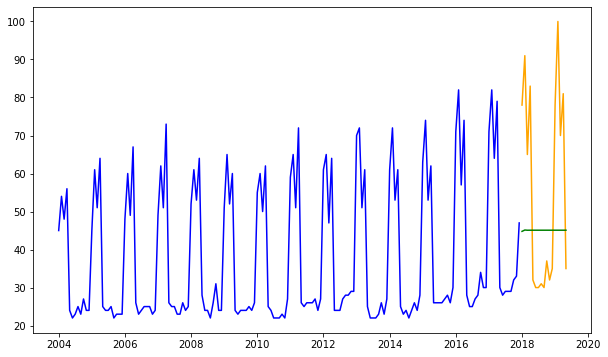

In [59]:
# Visualize it!
plt.figure(figsize=(10,6))
plt.plot(df_taxes.loc[df_taxes.future == 0, 'counts'], color='blue', label='actual train')
plt.plot(df_taxes.loc[df_taxes.future == 1, 'counts'], color='orange', label='actual test')
plt.plot(future_df['preds'], color='green', label='predicted test')

Thoughts? 

- Better but it's still not good


### Seasonal!

In [60]:
# Fit an ARMA model - what should our parameters be?
                                                                    
seas_arima = ARIMA(df_taxes.loc[df_taxes.future == 0]['counts'],
                   seasonal_order = (1,0,0,12))
                                    #P,D,Q,number of periods in our season
res_sarima = seas_arima.fit()

# Print out summary information on the fit
print(res_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:                 counts   No. Observations:                  168
Model:             ARIMA(1, 0, 0, 12)   Log Likelihood                -473.982
Date:                Mon, 08 Nov 2021   AIC                            953.965
Time:                        21:42:51   BIC                            963.337
Sample:                    01-01-2004   HQIC                           957.768
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.2139      6.423      6.105      0.000      26.624      51.804
ar.S.L12       0.9802      0.013     76.688      0.000       0.955       1.005
sigma2        13.1100      0.921     14.238      0.0

/Users/garrettwilliams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


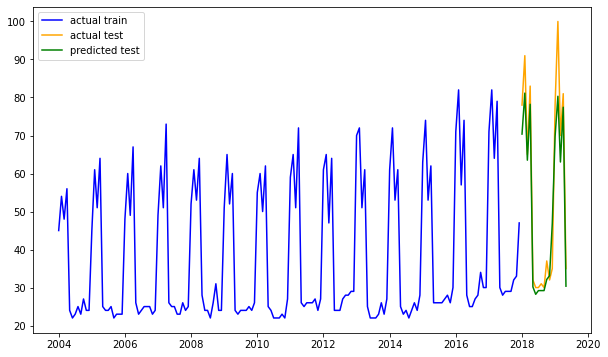

In [61]:
# Visualize it!
plt.figure(figsize=(10,6))
plt.plot(df_taxes.loc[df_taxes.future == 0, 'counts'], color='blue', label='actual train')
plt.plot(df_taxes.loc[df_taxes.future == 1, 'counts'], color='orange', label='actual test')
plt.plot(res_sarima.forecast(steps=len(y_test)), color='green', label='predicted test')
plt.legend();

### PMDArima - Using their Auto ARIMA! 

Basically, grid search for ARIMA

In [62]:
# Train test split - but now using PMDArima's function
train, test = model_selection.train_test_split(df_taxes['counts'], test_size=17)

In [63]:
train.head()

2004-01-01    45
2004-02-01    54
2004-03-01    48
2004-04-01    56
2004-05-01    24
Freq: MS, Name: counts, dtype: int64

In [64]:
train.tail()

2017-08-01    29
2017-09-01    29
2017-10-01    32
2017-11-01    33
2017-12-01    47
Freq: MS, Name: counts, dtype: int64

In [65]:
# checking stationarity
from pmdarima.arima.stationarity import ADFTest

# beyond statsmodels
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_taxes['counts'])  # (0.01, False)

print(f"P-Value: {p_val}, so should you difference the data? {should_diff}")

P-Value: 0.01, so should you difference the data? False


In [66]:
adf_test.should_diff(df_taxes['counts'])

(0.01, False)

In [67]:
# time to model!
arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, m=12) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=807.959, Time=2.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=836.996, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=809.988, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=815.075, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=847.586, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=808.559, Time=1.13 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=813.244, Time=0.48 sec
 ARIMA(2,0,2)(2,1,1)[12] intercept   : AIC=808.472, Time=3.05 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=809.335, Time=4.25 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=816.949, Time=0.22 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=807.352, Time=2.93 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=806.663, Time=0.69 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=807.851, Time=0.33 sec
 ARIMA(1,0,2)(1,1,2)[12] intercept   : AIC=808.596, Time=1.19 sec
 ARIMA(1,0,2)(1,1,1)[12] intercep

*(Regular order)(Seasonal Order)[Seasonal Difference or Component]*

*1 auto-regressive term <br>seasonal difference = 12<br> on the seasonal part it has a difference of 1, moving average = 2*

In [68]:
# check the output summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  168
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -397.122
Date:                                 Mon, 08 Nov 2021   AIC                            804.245
Time:                                         21:43:16   BIC                            819.494
Sample:                                              0   HQIC                           810.438
                                                 - 168                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4827      0.191      2.533      0.011       0.109       0.856
ar.L1          0.4667      0.082      5.678      0.000       0.306       0.628
ma.S.L12      -0.3146      0.077     -4.076      0.000      -0.466      -0.163
ma.S.L24      -0.1666      0.084     -1.994      0.046      -0.330      -0.003
sigma2         9.3536      0.804     11.635      0.000       7.778      10.929
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                96.61
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             1.07
Prob(H) (two-sided):                  0.21   Kurtosis:                         6.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Since AIC = 804 < 953 means this grid search model is doing better than our season model*

In [69]:
y_pred = arima.predict(n_periods=test.shape[0])

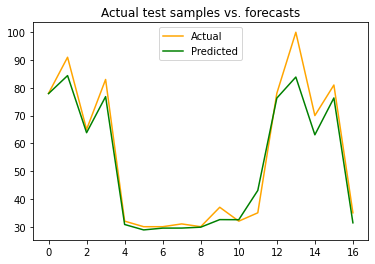

In [70]:
# Plot actual test vs. forecasts:
x = np.arange(test.shape[0])
plt.plot(x, test, color='orange', label='Actual')
plt.plot(x, arima.predict(n_periods=test.shape[0]), color='green', label='Predicted')
plt.title('Actual test samples vs. forecasts')
plt.legend()
plt.show()

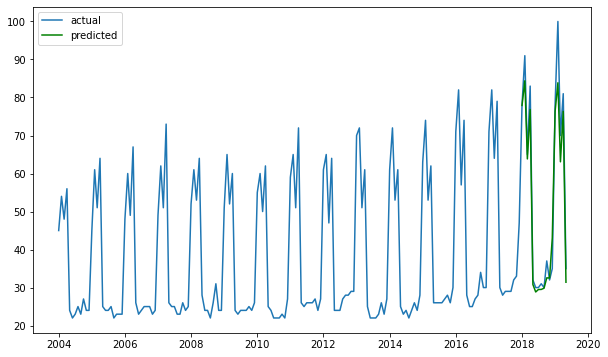

In [71]:
plt.figure(figsize=(10,6))
plt.plot(df_taxes['counts'], label = 'actual')
plt.plot(df_taxes.loc[df_taxes.future == 1].index, y_pred, color='green', label = 'predicted')
plt.legend()
plt.show()

In [72]:
report_metrics(y_test, y_pred)

Explained Variance:
	 0.9642132874531438
MAE:
	 3.799389478310142
RMSE:
	 5.524276172991079
r^2:
	 0.9519472906665967


Thoughts?

- really good


### Best (and Final) Model

In [73]:
# Fit the best fit model from grid search SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)
                                                                    
best_arima = ARIMA(df_taxes.loc[df_taxes.future == 0]['counts'], #just my data
                   order = (1,0,0), 
                   seasonal_order = (0,1,2,12))
                                    #P,D,Q,number of periods in our season
                   #trend = 'c')
best_sarima = best_arima.fit()

# Print out summary information on the fit
print(best_sarima.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                counts   No. Observations:                  168
Model:             ARIMA(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -401.772
Date:                               Mon, 08 Nov 2021   AIC                            811.544
Time:                                       21:43:16   BIC                            823.743
Sample:                                   01-01-2004   HQIC                           816.499
                                        - 12-01-2017                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5444      0.076      7.165      0.000       0.395       0.693
ma.S.L12   

More from the documentation: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#understand-p-d-and-q

> ARIMA models are made up of three different terms:
> 
> p: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.
> 
> d: The degree of differencing.
> 
> q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

OR:

> Seasonal ARIMA models have three parameters that heavily resemble our p, d and q parameters:
> 
> P: The order of the seasonal component for the auto-regressive (AR) model.
> 
> D: The integration order of the seasonal process.
> 
> Q: The order of the seasonal component of the moving average (MA) model.
> 
> P and Q and be estimated similarly to p and q via auto_arima, and D can be estimated via a Canova-Hansen test, however m generally requires subject matter knowledge of the data.

More gems at the end for those digging back into this notebook:

`pmdarima` has a set of tips and tricks: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

Also:

- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

And, what I'm really looking into right now:
- https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55